In [1]:
import numpy as np
import tensorflow as tf
import tensornets as nets
import os
from PIL import Image
from tqdm import tqdm, tqdm_notebook
import pickle
import math
#import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [2]:
def load_label_names():
    return ["Can", "Cookies", "Eggs", "Empty", "Fruit"]


In [3]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

In [4]:
with tf.device('cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [5]:
def getData(path, batchsize = 32):
    try:
        labels = np.load("batchedData/"+path+"/labels")
    except:
        print("No labels found", "batchedData/"+path+"/labels")
        return 0
    try:
        features = []
        i = 0
        while True:
            features.append(np.load("batchedData/"+path+'/'+str(i)))
            i = i+1
    except:
        return features, labels

In [6]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [7]:
test_features, test_labels = getData('preprocess_testing.p')

In [8]:
def display_image_predictions(features, labels, predictions):
    n_classes = 5
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 1.0

[0] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884758}, {'Cookies': 0.1488476}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.40460962}]

[1] ground truth: Cookies, predicted result: Cookies | True
	- [{'Can': 0.1488476}, {'Cookies': 0.4046095}, {'Eggs': 0.1488476}, {'Empty': 0.1488476}, {'Fruit': 0.14884765}]

[2] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884758}, {'Cookies': 0.14884758}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.40460968}]

[3] ground truth: Empty, predicted result: Empty | True
	- [{'Can': 0.14884801}, {'Cookies': 0.14884804}, {'Eggs': 0.14884825}, {'Empty': 0.40460622}, {'Fruit': 0.14884947}]

[4] ground truth: Cookies, predicted result: Cookies | True
	- [{'Can': 0.1488476}, {'Cookies': 0.4046097}, {'Eggs': 0.1488476}, {'Empty': 0.1488476}, {'Fruit': 0.1488476}]

[5] ground truth: Fruit, predicted resu

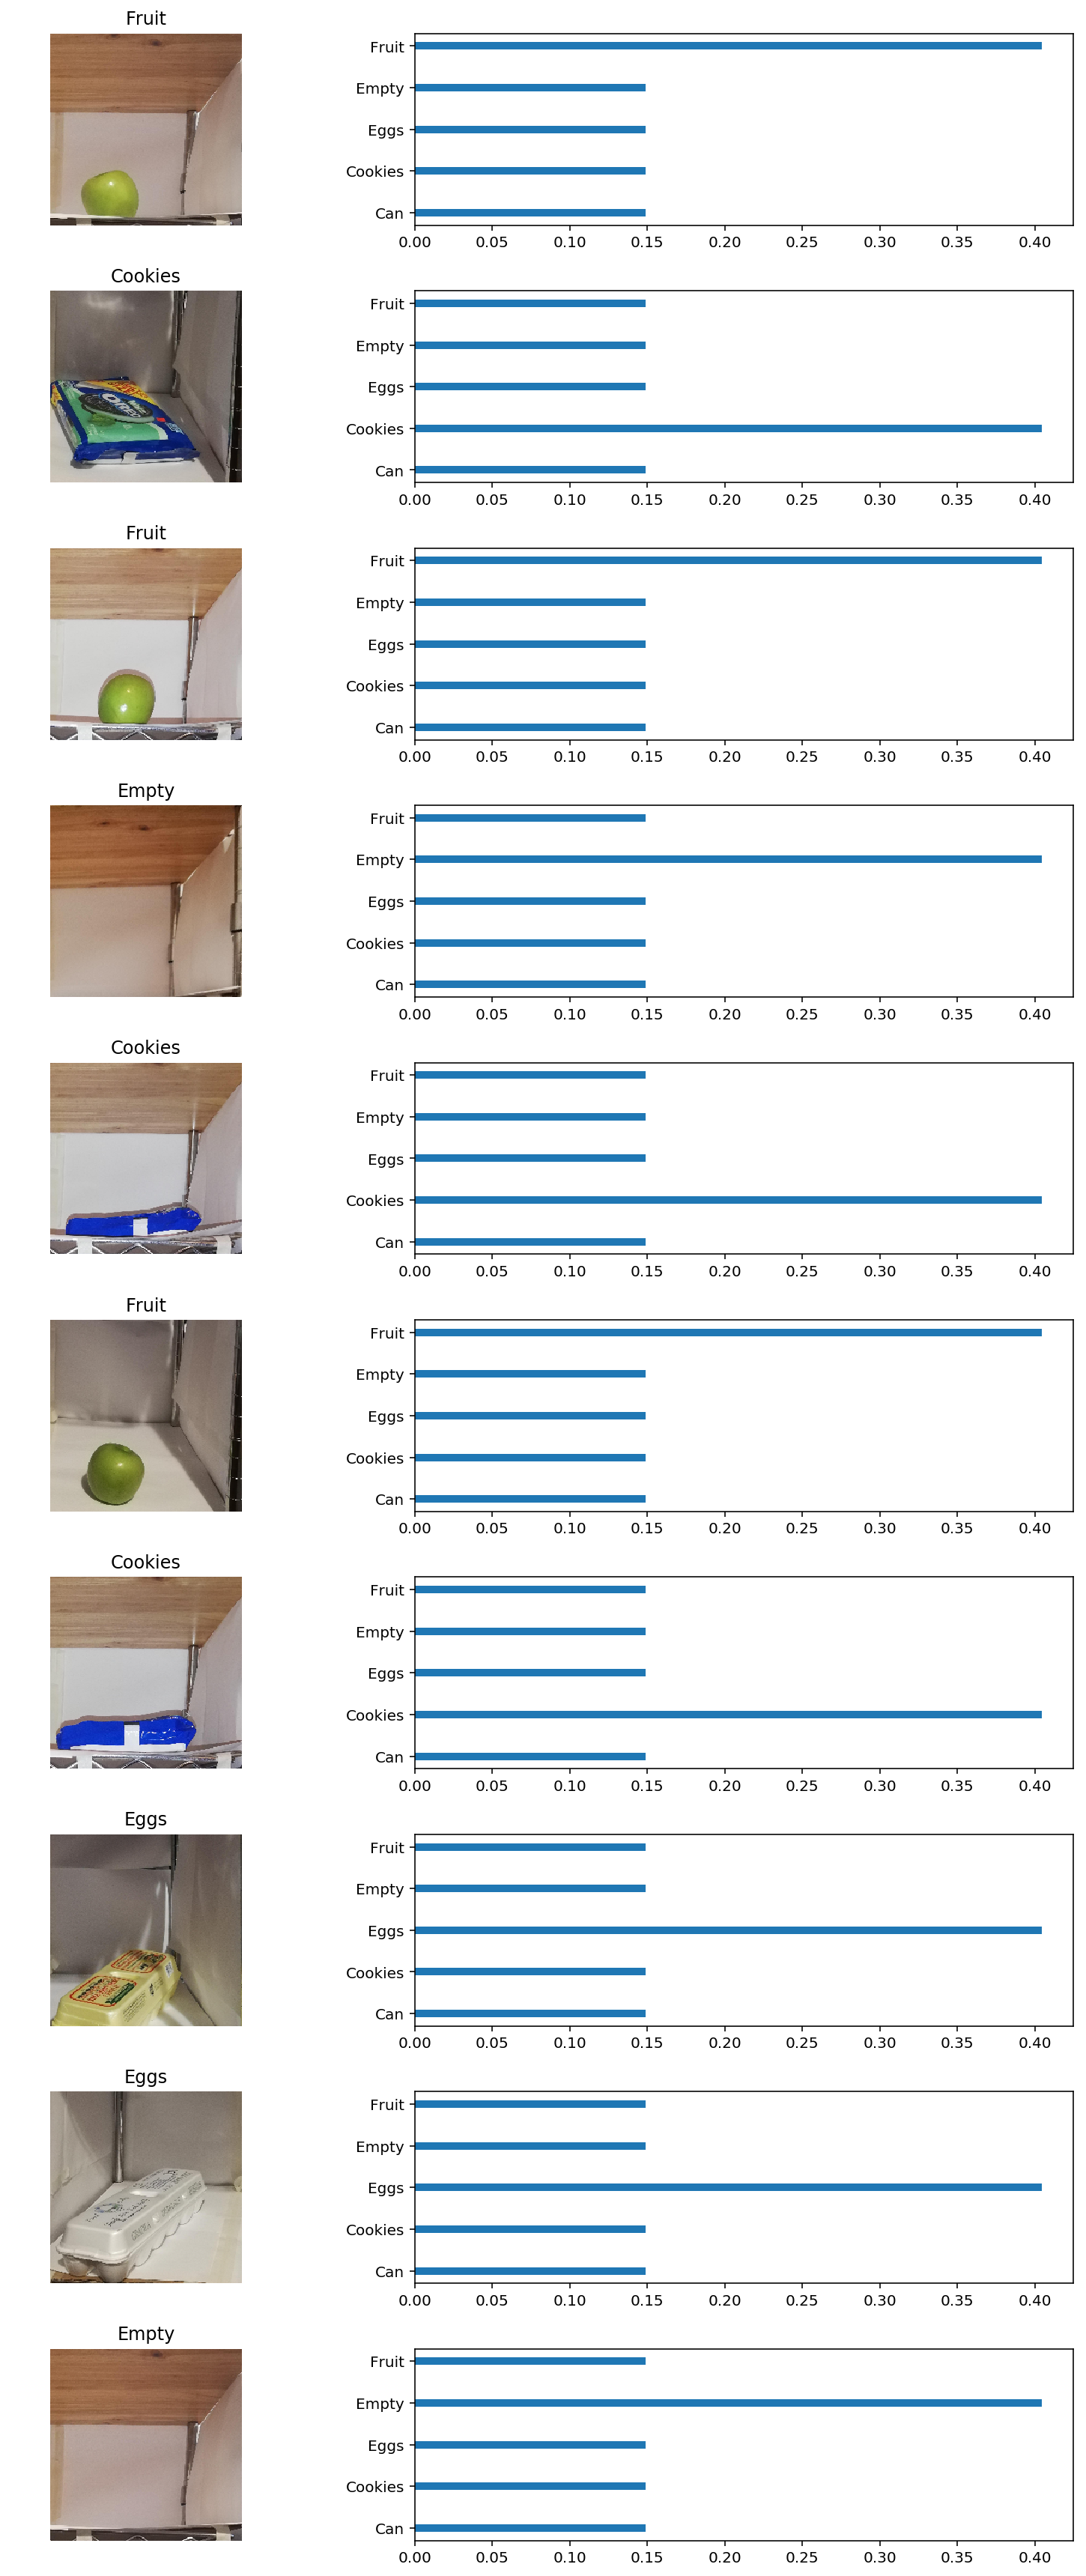

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 32
n_samples = 10
top_n_predictions = 5

def test_model(test_features):
    loaded_graph = tf.Graph()
    
    with tf.Session(config=config, graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta', clear_devices=True)
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(test_features)

